In [1]:
import torch
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()

chrs = ['.'] + sorted(list(set(''.join(words))))
chrs_to_idx = {c: i for i,c in enumerate(chrs)}
idx_to_chrs = {i: c for i,c in enumerate(chrs)}
num_of_chrs = len(chrs)

# Bigram

In [3]:
bigrams = torch.zeros(len(chrs),len(chrs), dtype=torch.int16)
for w in words:
    w_chrs = ['.'] + list(w) + ['.']
    for b in zip(w_chrs, w_chrs[1:]):
        bigrams[chrs_to_idx[b[0]], chrs_to_idx[b[1]]] += 1


In [4]:

# plt.figure(figsize=(16,16))
# plt.imshow(bigrams, cmap='Blues')
# for i,j in [(i,j) for i in range(len(chrs)) for j in range(len(chrs))]:
#     plt.text(j,i, idx_to_chrs[i]+idx_to_chrs[j],ha='center', va='bottom')
#     plt.text(j,i, bigrams[i,j].item(),ha='center', va='top')


In [6]:
g = torch.Generator().manual_seed(2147483647)
prob = bigrams / bigrams.sum(dim=1, keepdim=True)

def gen():
    i = 0
    w = []
    while True:
        i = torch.multinomial(prob[i], num_samples=1, replacement=True, generator=g).item()
        if i == 0:
            break
        w.append(idx_to_chrs[i])
        
    return ''.join(w) 

for i in range(5):
    print(gen())    

junide
janasah
p
cony
a


## loglikelihood loss


In [7]:
ll = 0.
n = 0
for w in words:
    w_chrs = ['.'] + list(w) + ['.']
    for b in zip(w_chrs, w_chrs[1:]):
        ll += torch.log(prob[chrs_to_idx[b[0]], chrs_to_idx[b[1]]])
        n += 1

print("minus log likelihood: ", -ll / n)


minus log likelihood:  tensor(2.4541)


## single layer neural net

In [8]:
xs = []
ys=[]
for w in words:
    w_chrs = ['.'] + list(w) + ['.']
    for b in zip(w_chrs, w_chrs[1:]):
        xs.append(chrs_to_idx[b[0]]) 
        ys.append(chrs_to_idx[b[1]])

xs = torch.tensor(xs)
ys = torch.tensor(ys)


### train loop

In [9]:
import torch.nn.functional as F

g = torch.Generator().manual_seed(2147483647)

W = torch.randn((27, 27), generator=g, requires_grad=True)
x_enc = F.one_hot(xs, num_classes=27).float()


In [14]:
for i in range(5000):
    logits = x_enc @ W
    counts = logits.exp()
    prob = counts / counts.sum(dim=1, keepdim=True)
    loss = -prob[torch.arange(ys.shape[0]), ys].log().mean()
    if i%100==0: print(i, loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # update weights
    W.data -= 1 * W.grad

0 2.454225778579712
100 2.454225540161133
200 2.454225778579712
300 2.454225540161133
400 2.454225540161133
500 2.454225540161133
600 2.4542253017425537
700 2.4542253017425537
800 2.4542250633239746
900 2.4542250633239746
1000 2.4542250633239746
1100 2.4542250633239746
1200 2.4542250633239746
1300 2.4542250633239746
1400 2.4542250633239746
1500 2.4542248249053955
1600 2.4542248249053955
1700 2.4542248249053955
1800 2.4542248249053955
1900 2.4542245864868164
2000 2.4542245864868164
2100 2.4542245864868164
2200 2.4542245864868164
2300 2.4542245864868164
2400 2.454224109649658
2500 2.454224109649658
2600 2.454224109649658
2700 2.454223871231079
2800 2.454223871231079
2900 2.454223871231079
3000 2.454223871231079
3100 2.4542236328125
3200 2.4542236328125
3300 2.4542236328125
3400 2.454223394393921
3500 2.454223394393921
3600 2.454223394393921
3700 2.454223394393921
3800 2.454223394393921
3900 2.454223394393921
4000 2.454223394393921
4100 2.454223155975342
4200 2.4542229175567627
4300 2.454

In [13]:
logits = x_enc @ W
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(ys.shape[0]), ys].log().mean()
print("all:", loss.item())

all: 2.454225778579712


In [91]:
g = torch.Generator().manual_seed(2147483647)
def gen2():
    i = 0
    w = []
    while True:
        logits = F.one_hot(torch.tensor(i), num_classes=len(idx_to_chrs)).float() @ W
        prob = logits.softmax(dim=1)
        i = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
        if i == 0:
            break
        w.append(idx_to_chrs[i])
        
    return ''.join(w) 

for i in range(5):
    print(gen2())   

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

# MLP

In [16]:

def build_dataset(ws, context_size):
    xs = []
    ys = []
    for w in ws:
        w_chrs = list(w) + ['.']
        context = [0]*context_size
        for c in w_chrs:
            xs.append(context) 
            ys.append(chrs_to_idx[c])
            context = context[1:] + [chrs_to_idx[c]]

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

context_size = 3
i = int(0.8*len(words))
j = int(0.9*len(words))

import random
random.seed(7)
random.shuffle(words)

xs, ys = build_dataset(words, context_size)
xs_train, ys_train = build_dataset(words[:i], context_size)
xs_dev, ys_dev = build_dataset(words[i:j], context_size)
xs_test, ys_test = build_dataset(words[j:], context_size)
print(xs_train.shape[0], xs_dev.shape[0], xs_test.shape[0])


182534 22760 22852


In [77]:
g = torch.Generator().manual_seed(2147483647)

embed_dim = 5
C = torch.randn((num_of_chrs, embed_dim))
W1 = torch.randn((embed_dim*context_size, 300))
b1 = torch.randn(W1.shape[1])
W2 = torch.randn((W1.shape[1], num_of_chrs))
b2 = torch.randn(W2.shape[1])
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

13062


In [78]:
batch_size = 60

# lossi = []
# lre = torch.linspace(-3,0,1000)
# lrii = 10**lre

def batch_forward(x,y):
    emb = C[x]
    m = torch.tanh(emb.view((-1, context_size*embed_dim)) @ W1 + b1)
    logits = m @ W2 + b2
    return F.cross_entropy(logits, y)

for i in range(200000):
    # batch
    idx = torch.randint(0, xs_train.shape[0], (batch_size,))
    x = xs_train[idx]
    y = ys_train[idx]
    # forward
    loss = batch_forward(x,y)

    # backwards
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    def lr():
        if i<100000: return  1e-1
        elif i<150000: return 1e-2
        else: return 1e-3
    lri = lr()
    for p in parameters:
        p.data += -lri * p.grad

    # lri.append(i)
    # lossi.append(loss.item())
    if i % 1000 == 0:
        print(i, loss.item())
    


0 31.815332412719727
1000 2.946598768234253
2000 2.8605165481567383
3000 2.599379777908325
4000 2.674997091293335
5000 2.8058102130889893
6000 2.7197022438049316
7000 2.389604091644287
8000 2.362464189529419
9000 2.398045063018799
10000 2.5223069190979004
11000 2.37623929977417
12000 2.589987277984619
13000 2.7209746837615967
14000 2.4425113201141357
15000 2.5649735927581787
16000 2.2295610904693604
17000 2.768744468688965
18000 2.2626163959503174
19000 2.5192530155181885
20000 3.03179669380188
21000 2.5672898292541504
22000 2.4312102794647217
23000 2.339897632598877
24000 2.5827412605285645
25000 2.1548588275909424
26000 2.4665205478668213
27000 2.0891032218933105
28000 2.615455150604248
29000 2.303227663040161
30000 2.615334987640381
31000 2.840022563934326
32000 2.3497157096862793
33000 2.117356777191162
34000 2.182185411453247
35000 2.409621477127075
36000 2.3095762729644775
37000 2.812910318374634
38000 2.373359441757202
39000 2.30637526512146
40000 2.478598117828369
41000 2.31388

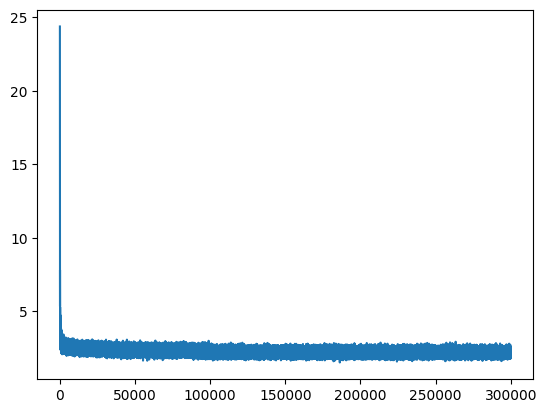

In [60]:
plt.plot(list(range(300000)), lossi)

In [79]:
loss = batch_forward(xs, ys)
print("all:", loss.item())
loss = batch_forward(xs_train, ys_train)
print("train:", loss.item())
loss = batch_forward(xs_dev, ys_dev)
print("dev:", loss.item())


all: 2.1634254455566406
train: 2.156360149383545
dev: 2.1952602863311768


In [80]:
loss = batch_forward(xs_test, ys_test)
print("test:", loss.item())

test: 2.1881537437438965


In [76]:
num_C = C.detach().numpy()
print(num_C.shape)
print(num_C[:,0])
f = go.Figure(go.Scatter3d(x=num_C[:,0],y=num_C[:,1],z=num_C[:,2], text=chrs, mode="markers"))
f.show()

(27, 3)
[-0.21051629  0.4651135   0.9678167   1.5283791  -0.03549856  0.22370246
  0.05884338  0.26314777  0.0165347  -0.04325281 -0.12550206 -0.00277822
 -0.5669253  -0.17700806 -0.41221038  0.2925384   0.18332364 -0.6108084
 -0.29116392 -0.01535065  0.02738359  0.16958687 -0.21189423 -0.00622117
  1.1273987  -0.2924037  -0.13241486]


In [93]:
g = torch.Generator().manual_seed(2147483647)
def gen3():

    context = [0]*context_size
    w = []
    while True:
        emb = C[context]
        m = torch.tanh(emb.view((-1, context_size*embed_dim)) @ W1 + b1)
        logits = m @ W2 + b2
        prob = logits.softmax(dim=1)
        # print(prob)
        idx = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [idx]
        if idx == 0:
            break
        w.append(idx_to_chrs[idx])
        
    return ''.join(w) 

for i in range(20):
    print(gen3())   

junnee
jakasid
pres
azaina
koi
ritolian
juham
sametauria
leviaj
dedaile
imel
sei
inayla
terindeumarif
demiyan
nastina
jaylinore
yaezon
kaevandreed
miki
